Marcin Wardyński  
czwartek, 8:00

## Lab 1

In [96]:
import regex
from collections import Counter
import matplotlib.pyplot as plt

In [97]:
from datasets import load_dataset

dataset = load_dataset("clarin-knext/fiqa-pl", name="corpus")

titles = dataset['corpus']['title']
not_empty_titles = titles = [title for title in titles if title != '']
print(f"There is {len(not_empty_titles)} not empty titles in the dataset")

There is 0 not empty titles in the dataset


In [98]:
corpus = dataset['corpus']

### Rozpoznawanie daty
Za słownikiem WSJP, datą nazywamy "numer określonego dnia, miesiąca, roku wskazany zgodnie z kalendarzem" (https://wsjp.pl/haslo/podglad/25270/data), tożsamą definicję podaje PWN. Ponieważ w poleceniu jest podany przykład używający jedynie dzień i miesiąc, zostanie on również zaliczony przez wyrażenie regularne dla daty.

Wszelkie pozostałe formaty definiujące punkt w czasie, np.: miesiąc i rok, lub też sam rok, zostaną pominięte.

Narodowe Centrum Kultury w poniższym artykule https://nck.pl/projekty-kulturalne/projekty/ojczysty-dodaj-do-ulubionych/ciekawostki-jezykowe/czy-wiecie-jak-poprawnie-zapisujemy-date-,c,50017 oraz słownik PWN w tym artykule: https://sjp.pwn.pl/poradnia/haslo/zapis-daty;10340.html podają właściwe sposoby zapisywania daty, użyję ich jako bazę do definicji przypadków zapisu dat, które powinny zostać rozpoznane przez wyrażenie regularne:
- 18.05.2023, 3.6.2023, 4.5.06, ale też z użyciem myślnika 03-05-2024, 1-9-1995 - zapis wyłącznie cyframi arabskimi. Do sprawdzenia występowanie formatu amerykańskiego używającego / jako separatora.
- 15 września 2021, 4 września 2021, też spotykane z miesiącem w mianowniku: 8 styczeń 2012 (możliwe, że i w innych przypadkach, co trzeba sprawdzić). Tylko ten format będzie akceptowany bez podanego roku, akceptacja pozostałych formatów bez podanego roku skutkowałaby zbyt dużą liczbą niewłaściwie rozpoznanych fragmentów tekstu jako daty.
- 15 wrz 2021 - czyli to co wyżej, tylko z nazwą miesiąca zapisaną trzyliterowym skrótem
- 10 X 2018, miesiąc w postaci liczby porządkowej w zapisie rzymskim

Pierwszy podlinkowany artykuł wspomina też o formacie, w którym zapis daty jest kompletnie słowny (np. dwudziesty siódmy kwietnia dwa tysiące dwunastego roku), jednakże jest to tak rzadki przypadek, że nie będzie on brany pod uwagę.

#### Sprawdzanie przypadków szczególnych

- format amerykański używający ukośnika (/)
- dzień + miesiąc w innym przypadku, niż dopełniacz lub mianownik.

Najpierw data z ukośnikami:

In [119]:
am_date_pattern = regex.compile(r"(?<!http\S+)\d{1,4}\s*\/\s*\d{1,2}\/\s*\d{1,4}", flags=regex.IGNORECASE | regex.MULTILINE)

top = 5

for entry in corpus:
    found = regex.findall(am_date_pattern, entry['text'])

    if found and top > 0:
        top -= 1
        print(entry['_id'])
        print(entry['text'][0:100])

6760
„***JamieJBartlett***: >&#91;2012/10/22&#93;&#91;17:30:33&#93; >[&#91;Przetłumacz&#93;](http:// tran
13187
Jeśli chodzi o punkt c, jeśli uważasz, że firmy muszą płacić powyżej poziomu świadczeń socjalnych, r
13680
Plan podatkowy Trumpa jest silnie wzorowany na planie podatkowym republikańskiego gubernatora stanu 
13800
POS to skrót od Point of Sale (podobnie jak konkretna lokalizacja sklepu), który wskazuje, że zakup 
15019
Działania STEM, które oznaczają naukę, inżynierię, inżynierię i matematykę, to cały szum w edukacji.


Wynik powyższego kodu (ale bez ograniczania długości i ilości wyników) został przeglądnięty i z 95 odnalezionych dokumentów spełniających zadane wyrażenie regularne, jedynie następujących siedem jest faktycznymi datami w formacie amerykańskim: 307602, 320073, 338943, 359713, 395906, 397212, 456470. Zdecydowana większość wśród pozostałych to niewłaściwie sformatowane adresy URL, do których zakradła się spacja, a poza nimi wyrażenia określające proporcje, czy też nazwy własne.

Poniże sprawdzę inne przypadki miesiąca, niż mianownik i dopełniacz. Liczbę mnogą myślałem odrzucić bez sprawdzania, ale jednak dla pewności dopiszę do testowanych przypadków.

In [100]:
jan_pattern = "styczniowi|styczniem|styczniu|stycznie|styczniów|styczni[^a]|styczniom|styczniami|styczniach"
feb_pattern = "lutemu|lutym|lute[^g][^o]|lutych|lutymi"
mar_pattern = "marcowi|marcem|marcu|marce|marców|marcom|marcami|marcach"
apr_pattern = "kwietniowi|kwietniem|kwietniu|kwietnie|kwietni[^a]|kwietniów|kwietniom|kwietniami|kwietniach"
may_pattern = "majowi|majem|maju|maje|majów|majom|majami|majach"
jun_pattern = "czerwcowi|czerwcem|czerwcu|czerwce|czerwców|czerwcom|czerwcami|czerwcach"
jul_pattern = "lipcowi|lipcem|lipcu|lipce|lipców|lipcom|lipcami|lipcach"
aug_pattern = "sierpniowi|sierpniem|sierpniu|sierpnie|sierpni[^a]|sierpniów|sierpniom|sierpniami|sierpniach"
sep_pattern = "wrześniowi|wrześniem|wrześniu|wrześnie|wrześni[^a]|wrześniów|wrześniom|wrześniami|wrześniach"
oct_pattern = "październikowi|październikiem|październiku|październiki|październików|październikom|październikami|październikach"
nov_pattern = "listopadowi|listopadem|listopadzie|listopady|listopadów|listopadom|listopadami|listopadach"
dec_pattern = "grudniowi|grudniem|grudniu|grudnie|grudni[^a]|grudniów|grudniom|grudniami|grudniach"

pattern = regex.compile(rf"\d\s*({jan_pattern}|{feb_pattern}|{mar_pattern}|{apr_pattern}|{may_pattern}|{jun_pattern}|{jul_pattern}|{aug_pattern}|{sep_pattern}|{oct_pattern}|{nov_pattern}|{dec_pattern})", flags=regex.MULTILINE | regex.UNICODE)
for entry in corpus:
    found = regex.findall(pattern, entry['text'])

    if found:
        print(entry['_id'])
        print(entry['text'])


Jak widać, po podaniu numeru dnia, miesiące w innej odmianie przez przypadki niż mianownik lub dopełniacz nie występują, więc przy specyfikacji wyrażenia regularnego można je pominąć.

### Właściwe wyrażenie regularne do rozpoznawania dat

In [101]:
months_nom = ["styczeń", "luty", "marzec", "kwiecień", "maj", "czerwiec", "lipiec", "sierpień", "wrzesień", "październik", "listopad", "grudzień"]
months_gen = ["stycznia", "lutego", "marca", "kwietnia", "maja", "czerwca", "lipca", "sierpnia", "września", "października", "listopada", "grudnia"]
months_3 = ["sty", "lut", "mar", "kwi", "maj", "cze", "lip", "sie", "wrz", "paż", "lis", "gru"]
months_roman = ["I", "II", "III", "IV", "V", "VI", "VII", "VIII", "IX", "X", "XI", "XII"]

months_nom_p = "|".join(months_nom)
months_gen_p = "|".join(months_gen)
months_3_p = "|".join(months_3)
months_roman_p = "(?-i)"+"|".join(months_roman)+"(?i)I"

months_w_year = f"{months_3_p}|{months_roman_p}"
months_wo_year = f"{months_nom_p}|{months_gen_p}"
separator = r"(?:\s+|\s*[\.\-]\s*)"

date_pattern = regex.compile(rf"\b(\d{{1,4}}){separator}(?:(?:({months_wo_year})(?:{separator}(\d{{1,4}}))?)|(?:(?:(1?\d)|({months_w_year})){separator}(\d{{1,4}})))\b", flags=regex.IGNORECASE | regex.MULTILINE)


dates = []

for entry in corpus:
    found = regex.findall(date_pattern, entry['text'])
    for date in found:
        dates.append(date)

#### Uwagi do stworzonego wyrażenia regularnego

Powyższa list `dates` zawiera krotki gdzie poszczególne pozycje odpowiadają następującym wartościom:
1. Dzień, chyba że data jest w formacie YMD, wtedy rok
2. Pełna nazwa miesiąca w mianowniku lub dopełniaczu
3. Rok, jeśli został podany po miesiącu o pełnej nazwie. Jeśli data w formacie YMD, to wtedy dzień
4. Miesiąc w postaci cyfry arabskiej - może występować wyłącznie, gdy jest podany rok w grupie szóstej
5. Miesiąc w postaci trzyliterowej lub rzymskiej - może występować wyłącznie, gdy jest podany rok w grupie szóstej
6. Rok, gdy miesiąc znajduje się w grupie czwartej lub piątek. Dzień przy formacie daty YMD

Jak widać w powyższym opisie, specyfikacja miesiąca w postaci liczb arabskich, rzymskich lub trzyliterowego skrótu zostaje uznana wyłącznie, gdy data posiada też rok. W innym wypadku wyrażenie regularne zbierało zbyt dużo fałszywych wyników, gdyż zapisy np. przedziałów, nazw własnych itp. w dużej mierze też się kwalifikowały.

In [102]:
def extract_month(date):
    if date[1]:
        try:
            return months_gen.index(date[1].lower())+1
        except ValueError:
            pass

        try:
            return months_nom.index(date[1].lower())+1
        except ValueError:
            return None
    elif date[3]:
        month_idx = int(date[3])
        return month_idx if 1 <= month_idx <= 12 else None
    else:
        try:
            return months_roman.index(date[4].upper())+1
        except ValueError:
            pass

        try:
            return months_3.index(date[4].lower())+1
        except ValueError:
            return None

def extract_day_and_year(date):
    day = int(date[0])
    year = None
    if date[2]:
        year = int(date[2])
    elif date[5]:
        year = int(date[5])

    if year is None:
        return (day, year) if 1 <= day <= 31 else (None, None)
    else:
        if 1 <= day <= 31 and year > 0:
            return (day, year)
        elif 1 <= year <= 31 and day > 0:
            return (year, day)
        else:
            return (None, None)

    

def parse_date(date):
    month = extract_month(date)
    day, year = extract_day_and_year(date)
    return (day, month, year) if day and month else (None, None, None)

f_dates = []

for date in dates:
    day, month, year = parse_date(date)
    if day and month:
        f_dates.append((day, month, year))

len(f_dates)


1637

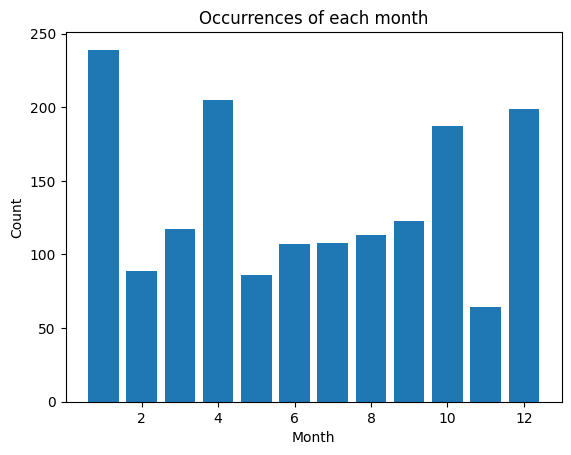

In [103]:
months = [date[1] for date in f_dates]
months_counter = Counter(months)

plt.bar(list(months_counter.keys()), list(months_counter.values()))
plt.title('Occurrences of each month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

### Rozpoznawanie czasu

Rozważane formaty podawania czasu:
1. HH:MM
2. HH:MM:SS
Mogą istnieć dodatkowe elementy, jak specyfikacja strefy czasowej, lub setne/tycięczne sekundy

In [104]:
time_sperator = r"(?:\s*:)"

time_pattern = regex.compile(rf"([0-2]?\d){time_sperator}([0-5]\d)(?:{time_sperator}([0-5]\d))?", flags=regex.IGNORECASE | regex.MULTILINE)

times = []

for entry in corpus:
    found = regex.findall(time_pattern, entry['text'])
    for time in found:
        times.append(time)

len(times)

470

In [105]:
def parse_time(time):
    h = int(time[0])
    m = int(time[1])
    if 0 <= h <= 23 and 0 <= m <= 59:
        s = int(time[2]) if time[2] else 0
        if 0 <= s <= 59:
            return (h, m, s)
    return (None, None, None)


f_times = []

for time in times:
    h, m, s = parse_time(time)
    if h is not None and m is not None:
        f_times.append((h, m, s))

len(f_times)


465

#### Uwagi do stworzonego wyrażenia regularnego

Uzycie wszelkiego innego separatora, niż ':' znacznie zwiększa ilość otrzymywanych wyników, lecz większość z nich nie jest wyznaczeniem godziny, lecz numerem wersji, kwantyfikatorem lub nazwą własną. Z tego powodu jedynym słusznym sepratorem pozostaje dwukropek.

Wymuszam użycie formatu dwucyfrowego dla podawanej liczby minut, żeby wyciąć szum związany z podawaniem np stosunku wartości, typu 1:4 (1 do 4).

Istnieje kilka wpisów zawierających godzinę, w której to separatorowi ':' towarzyszy jakaś spacja, natomiast jeśli spacja następuje po separatorz, bardzo często łapią się wykazy, gdzie to po liczbie porządkowej danego przypadku następuje dwukropek, później spacja i wartość liczbowa odpowiadająca danemu przypadkowi. Żeby uwzględnić choć część godzin ze spacją przy separatorze, ale zarazem wykluczyć wszystkie wykazy dopuszczam spację wyłącznie przed separatorem.

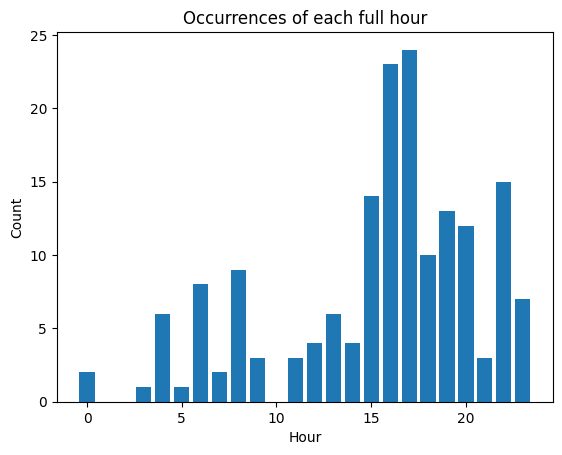

In [106]:
full_h_times = [time for time in f_times if time[1] == 0 and time[2] == 0]
only_full_h = [h[0] for h in full_h_times]
full_h_counter = Counter(only_full_h)

plt.bar(list(full_h_counter.keys()), list(full_h_counter.values()))
plt.title('Occurrences of each full hour')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.show()

### Wnioski

Generalnie sztuka tworzenia wyrażeń regularnych polega na odnalezieniu właściwego balansu pomiędzy wariantem restrykcyjnym i dość luźno dopasowującym. Wyrażenie regularne mają problem z uwzględnieniem kontekstu w efektywny sposób, więc zawsze należy się liczyć z pewną ilością zaakceptowanych próbek, które nie są prawidłowe.

Zmniejszając precyzyjność wyrażenia regularnego możemy znaleźć więcej dat zapisanych w złym formacie, ale znajdziemy też zdecydowanie więcej elementów nie będących datą, np. separator pomiędzy grupami w postaci "\s*[\.\-]?\s*" pozwala na dość luźne obchodzenie się z pustymi znakami i separatorami w dacie, ale dozwala też cyfry bez separatora.  
Dodatkowa obróka dla znalezionych wyrażeń, potencjalnie będących datami, wydaje się nieunikniona.

Godziny mają mniej możliwych formatów i kolejność ich podawania jest jednoznaczna, stąd wyrażenie regularne było łatwiejsze do skonstruowania.

### Zliczanie słowa "kwiecień"
#### Samo słowo "kwiecień" w pełnej odmianie:

Za stroną http://morfeusz.sgjp.pl/ pełna fleksja słowa "kwiecień" wygląda w następujący sposób:

- **kwie** *cień*
- **kwie** *tni* a
- **kwie** *tni* owi
- **kwie** *tni* em
- **kwie** *tni* u
- **kwie** *tni* e
- **kwie** *tni*
- **kwie** *tni* ów
- **kwie** *tni* om
- **kwie** *tni* ami
- **kwie** *tni* ach

Jak widzimy powyżej, wszystkie formy zawierają rdzeń **kwie**, po czym dla mianownika liczby pojedyńczej następuje *cień*, natomiast w wszystkich pozostał przypadkach *tni* plus typowy dla przypadku suffix.  
Właśnie opierając się o tą obserwację tworzę następujące wyrażenie regularne do użycia w kolejnym zadaniu: "kwie(cień|tni)"

In [107]:
april_flex = ["kwiecień", "kwietnia", "kwietniowi", "kwietniem", "kwietniu", "kwietnie", "kwietni", "kwietniów", "kwietniom", "kwietniami", "kwietniach"]
april_flex_p = "|".join(april_flex)

april_p = r"kwie(cień|tni)"

def count_april_occurrences(what, pattern):
    occurrences = {}
    counter = 0

    for entry in corpus:
        found = regex.findall(pattern, entry['text'])
        
        counter += len(found)
        if found:
            occurrences[entry["_id"]] = len(found)

        
        
    print(f"{what} found in {len(occurrences.keys())} documents in total {counter} times.")
    return occurrences


occ_april = count_april_occurrences("April (directly)", april_flex_p)
occ_april = count_april_occurrences("April (compact)", april_p)

April (directly) found in 263 documents in total 359 times.
April (compact) found in 263 documents in total 359 times.


Kwiecień we wszystkich formach odmiany występuje w zadanym tekście 359 razy, w 263 różnych dokumentach.

Kompaktowe wyrażenie regularne powinno być sformułowane poprawnie, gdyż daje dokładnie ten sam wynik, co wyrażenie zawierające wszystkie formy odmiany.

In [108]:
april_after_num_p = rf"(?<=\d ){april_p}"
occ_april_after_num = count_april_occurrences("April preceded by a number and a space", april_after_num_p)

April preceded by a number and a space found in 139 documents in total 201 times.


In [109]:
april_not_after_num_p = rf"(?<!\d ){april_p}"
occ_not_april_after_num = count_april_occurrences("April not preceded by a number and a space", april_not_after_num_p)

April not preceded by a number and a space found in 135 documents in total 158 times.


Co więcej, wyszukując nazwy "Kwiecień" jak w punkcie poprzednim, lecz dodając niezależnie dwa warunki: o występowaniu liczby i spacji przed nazwą miesiąca, oraz o nie występowaniu, suma tych dwóch wyszukiwań daje dokładnie ten sam wynik, co w punkcie poprzednim, który nie posiadał żadnych warunków.

Poniższy kod dodatkowo jeszcze to spradza poprzez:
- porównanie zbiorów zawierających identyfikatory dokumentów ze słowem "kwiecień"
- sprawdzenie, czy dla każdego dokumentu, suma z wyrażeń warunkowych odpowiada liczbie wyników bez warunku.

In [110]:
def find_docs_with_diff_occ(all, sub1, sub2):
    diff = {}
    for key in all.keys():
        all_v = all[key]
        sub1_v = sub1[key] if key in sub1 else 0
        sub2_v = sub2[key] if key in sub2 else 0
        if all_v != sub1_v+sub2_v:
            diff[key] = f"all#: {all_v}, sub1{sub1_v}, sub2{sub2_v}"

    return diff

docs_diff = set(occ_april.keys()) - (set(occ_april_after_num.keys()) | set(occ_not_april_after_num.keys()))
occ_diff = find_docs_with_diff_occ(occ_april, occ_april_after_num, occ_not_april_after_num)

(docs_diff, occ_diff)


(set(), {})

Jak widzimy zbiory i słowniki, które powinny zawierać różnice pomiędzy podejściami, są puste.

## Wyrażenia regularne do powyższych poleceń w wykonaniu Bielika

Polecenia zostały wydane Bielikowi w wersji 1.0, wydanej 18.10.2024

Polecenie z dnia 20.10.2024:
```
podaj mi jedno wyrażenie regularne, które dobrze znajduje godzinę, minuty i sekundy (jeśli te zostały podane)
```

Odpowiedź:
```
\b(?:(?:[01]?[0-9]|2[0-3]):)?(?:[0-5][0-9])?(?::[0-5][0-9])?\b
```

Polecenie z dnia 20.10.2024:
```
Podaj mi jedno wyrażenie regularne najlepiej nadające się do znajdowania daty w tekście, gdzie miesiąc mógł zostać zapisany słownie lub liczbowo używając cyfr arabski oraz rzymskich
```

Odpowiedź:
```
\b(?:\d{1,2}\.){1,2}(?:\d{1,4}|(?:\d{1,2}\.?\d{1,2}))(?:\s(?:stycznia|lutego|marca|kwietnia|maja|czerwca|lipca|sierpnia|września|października|listopada|grudnia|styczniu|lutym|marcu|kwietniu|maju|czerwcu|lipcu|sierpniu|wrześniu|październiku|listopadzie|grudniu))?\b
```

Polecenie z dnia 20.10.2024:
```
Stwórz wyrażenie regularne, które odnajdue w tekście wszystkie wystąpienia słowa "Kwiecień" we wszystkich odmianach przez przypadki, ale samo wyrażenie nie może zawierać wszystkich przypadków zdefiniowanych wprost
```

Odpowiedź:
```
\b(?:k|K)wiet[ań]?[ę]?\b
```

Polecenie z dnia 20.10.2024:
```
zmodyfikuj powyższe wyrażenie regularne tak, żeby akceptowało słowo "Kwiecień" jedynie jeśli znajduje za liczbą i spacją
```

Odpowiedź:
```
\b\d+\s(?:k|K)wiet[ań]?[ę]?\b
```

Polecenie z dnia 20.10.2024:
```
Jeszcze raz zmodyfikuj początkowe wyrażenie do odnajdowania słowa "Kwiecień", jednak tym razem mają zostać odnalezione tylko te słowa, które nie znajdują się zaraz za liczbą i spacją
```

Odpowiedź:
```
\b(?:(?<!\d+\s)k|K)wiet[ań]?[ę]?\b
```



### Zliczanie wystąpień pełnych godzin przy użyciu wyrażenia regularnego od Bielika

Niestety wyrażenie od Bielika nie nadaje się do użycia wprost, gdyż w zaproponowanej formie odnajduje wyłącznie puste ciągi znaków. Można zauważyć, że wszystkie wyspecyfikowane grupy w wyrażeniu nie są grupami matchującymi, a dodatkowo wystąpienie każdej z grup jest opcjonalne. Dobrze natomiast wygląda sama definicja zakresu cyfr mogących wystąpić w każdym miejscu podanego czasu.

Dokonałem jego drobnej korekty, która przynosi porządane wyniki. Generalnie wyrażenie regularne od LLM było całkiem dobrze pomyślane, lecz detale nie pozwalały mu na właściwe funkcjonowanie.

Matches after regex: 448
Dates after cleaning: 448


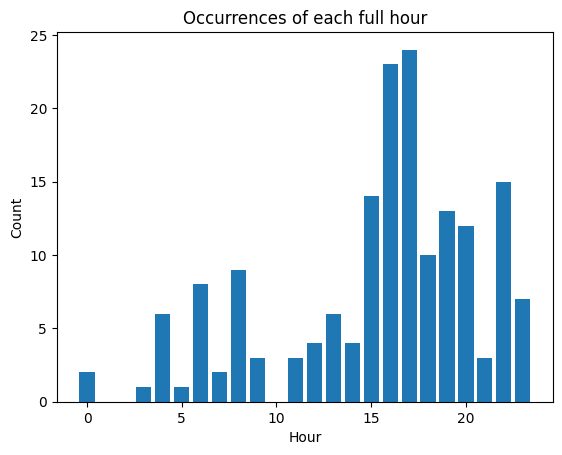

In [111]:
time_llm_pattern = regex.compile(r"\b(?:(?:[01]?[0-9]|2[0-3]):)?(?:[0-5][0-9])?(?::[0-5][0-9])?\b", flags=regex.IGNORECASE | regex.MULTILINE)
corrected_time_llm_pattern = regex.compile(r"\b(?:([01]?[0-9]|2[0-3]):)([0-5][0-9])(?::([0-5][0-9]))?\b", flags=regex.IGNORECASE | regex.MULTILINE)


times = []
for entry in corpus:
    found = regex.findall(corrected_time_llm_pattern, entry['text'])
    for time in found:
        times.append(time)

print(f"Matches after regex: {len(times)}")

f_times = []
for time in times:
    h, m, s = parse_time(time)
    if h is not None and m is not None:
        f_times.append((h, m, s))

print(f"Dates after cleaning: {len(f_times)}")

full_h_times = [time for time in f_times if time[1] == 0 and time[2] == 0]
only_full_h = [h[0] for h in full_h_times]
full_h_counter = Counter(only_full_h)

plt.bar(list(full_h_counter.keys()), list(full_h_counter.values()))
plt.title('Occurrences of each full hour')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.show()


Po wprowadzeniu poprawek do wyrażenia regularnego otrzymujemy wyniki niemalże identyczne z moimi. Poprawione wyrażenie regularne od LLM znalazło finalnie o 17 wystąpień czasu w tekście mniej, niż moje wyrażenie regularne.  
Fakt ten nie powinien dziwić, gdyż wyrażenie to było bardziej rygorystyczne w swojej formie przez specyfikację zakresu cyfr na poszczególnych pozycjach. Dobrą jakość odnalezionych wyników przy pomocy wyrażenia regularnego widać też po tym, że czyszczenie wyników nie usunęło żadnego ze znalezionych rezultatów.

### Zliczanie wystąpień miesięcy przy użyciu wyrażenia regularnego od Bielika

W przypadku odnalezie daty LLM kompletnie się pogubił i zaproponowane wyrażenie nie może przynosić dobrych wyników. Ponownie wszystkie zdefiniowane grupy nie są matchującymi, miesiące słownie zostały doklejone na końcu wyrażenia, a przecież raczej występują w środku daty, liczb rzymskich kompletnie zabrakło, i dodatkowo część wyrażenia odpowiadająca za rok może przyjąc postać czterocyfrową (czyli ok), lub dwa razy dwiecyfry, a pomiędzy każdą z tych dwójek kropka. 

In [120]:
date_llm_pattern = regex.compile(r"\b(?:\d{1,2}\.){1,2}(?:\d{1,4}|(?:\d{1,2}\.?\d{1,2}))(?:\s(?:stycznia|lutego|marca|kwietnia|maja|czerwca|lipca|sierpnia|września|października|listopada|grudnia|styczniu|lutym|marcu|kwietniu|maju|czerwcu|lipcu|sierpniu|wrześniu|październiku|listopadzie|grudniu))?\b", flags=regex.IGNORECASE | regex.MULTILINE)

dates = []

for entry in corpus:
    found = regex.findall(date_llm_pattern, entry['text'])
    for date in found:
        dates.append(date)

dates[:30]

['0.1',
 '0.1',
 '0.1',
 '1.65',
 '0.0048',
 '0.58',
 '0.01',
 '0.01',
 '46.667',
 '3.333',
 '1.5',
 '1.65',
 '1.65',
 '16.500',
 '1.65',
 '14.05.2010',
 '18.05.2010',
 '14.07.2010',
 '4.1',
 '1.65',
 '1.200',
 '3.11',
 '1.65',
 '1.65',
 '1.05',
 '1.05',
 '1.65',
 '1.65',
 '1.65',
 '7.800']

W związku z tym, że powyższe wyrażenie regularne jedynie w wąskim zakresie będzie zwracało daty, a większość wyników to szum, nie wprowadzam dalszych korekt i nie przedstawię wykresu przedstawiającego liczbę miesięcy na jego podstawie, gdyż już teraz nie widać zasadności używania tego wyrażenia.

### Analiza przez Bielika występowania słowa "Kwiecień" w tekście

Wyrażenie regularne zwrócone przez LLM do odnajdowania słowa "Kwiecień" we wszystkich przypadkach nie działa. Wyrażenie dla przypomnienia wygląda tak:`\b(?:k|K)wiet[ań]?[ę]?\b` i już na pierwszy rzut oka można powiedzieć, że w przeciwieństwie do prawidłowej definicji nie znajdzie ani jednego wystąpienia tego słowa.

Wyrażenie oczekuje od dopasowywanego łańcucha znaków, żeby zaczynało się od "kwiet", a tym warunkiem wyklucza mianownik l.poj., natomiast po "t" oczekuje "ań" lub "ę", a wszystkie formy poza mianownikiem mają na tej pozycji litery "ni", czym wyklucza pozostałe przypadki. q.e.d. :D

Warianty tego zapytania sprawdzające występowania, lub jego brak, liczby oraz spacji przed nazwą "Kwiecień" bazują na tym samym wyrażeniu, więc już wiemy, że nie zadziałają. Przyjrzyjmy się więc wyłącznie sposobowi realizacji warunku dotyczącego liczby i spacji:

1. Wyrażenie dla liczby i spacji przed słowem "Kwiecień": `\b\d+\s(?:k|K)wiet[ań]?[ę]?\b` - dodatkowy warunek się zgadza, ale nie używa formuły *positive lookbehind*
2. Wyrażenie bez liczby i spacji przed słowem "Kwiecień": `\b(?:(?<!\d+\s)k|K)wiet[ań]?[ę]?\b` - warunek się zgadza i używa formuły *negative lookbehind*



## Dodatkowe pytania

#### Czy wyrażenia regularne są dobre do rozpoznawania czasu?

Jak zauważyłem przy tworzeniu wyrażenia regularnego dla rozpoznawania czasu, format podawania czasu w języku polskim jest dość prosty i dobrze ustandaryzowany, czyniąc go dobrym kandydatem do bycia rozpoznawanym przez wyrażenia regularne. Należy się liczyć z tym, że wciąż przypadkiem można zakwalifikować jako czas inne wyrażenie, np. stosunek 1:4, jednak przypadki te są marginalne w porównaniu do wyrażeń faktycznie zawierających czas, gdyż dwukropek pomiędzy dwoma liczbami jest bardzo charakterystyczny dla zapisu czasu.

#### Czy wyrażenia regularne są dobre do rozpoznawania dat?

Format daty jest na tyle złożony i dopuszczający wiele wariantów, że wyrażenia regularne zaczynają mieć problemy z ich właściwą kwalifikacją.  
W formacie daty istnieje wiele czynników komplikujących jego definicję, jak:
- kolejność DMY lub YMD
- rok zapisany przy użyciu czterech cyfr, lub skrótowo dwóch
- format zapisu miesiąca
- separator pomiędzy poszczególnymi elementami daty

Na domiar złego separatory elementów składowych daty, czyli najczęściej kopka lub spacja, występują na tyle często w innych wyrażeniach, że nie trudno o dużą liczbę false postives. Fakt ten zachęca do zwiększania dokładności wyrażenia, co z kolei doprowadzi do wykluczenia pewnych wyrażeń będących datami, lecz sformatowanymi odrobinę inaczej, lub z małym błędem.

Jak pisałem we wnioskach do wykonanego ćwiczenia, wymagany jest tu balans pomiędzy restrykcyjnością wyrażenia, a akceptacją wyrażeń false positive. Do lepszego kwalifowania wyrażeń jako daty potrzebowalibyśmy informacji na temat kontekstu ich występowania.


#### Jak można być pewnym, że wyrażenie regularne dopasowało wszystkie i wyłącznie poprawne wyrażenia danego typu?

Pytanie to sprowadza się do problemu stosunku `Precision` do `Recall`, który ilustruje poniższa grafika:

![precision-recall](_img_precision-recall.png)

Przy przetwarzaniu języka naturalnego istnieje tak wiele składowych, że nawet przy rozważaniu dość prostego wyrażenia regularnego w stosunkowo dobrze przygotowanym tekście, wciąż możemy się natknąć na pewne niejednoznaczności językowe, które zaburzą otrzymane wyniki.

Przykładem tekstu, gdzie uzyskanie `Precision` i `Recall` powinno być normą, to tekst tworzony przez maszynę w precyzyjnie określonym formacie, jak np. logi działającego serwera. Parsując takie logi, znamy dokładnie miejsce oraz format zapisu poszukiwanego wyrażenia, przez co np. wyszukiwanie wszystkich wpisów dokonancyh o wyspecyfikowanej dacie nie stwarza problemów.

#### Czy LLM umie w regex?

Nie, nie umie, a przynajmniej Bielik nie umie. Żadne z uzyskanych wyrażeń regularnych w tym zestawie ćwiczeń nie nadawało się do bezpośredniego wykorzystania.

Jeszcze dla formatu czasu potrafię sobie wyobrażić, że odpowiednia budowa zapytania naprowadziłaby w końcu model na właściwe wyrażenie regularne, natomiast dla wyrażenia o większej złożoność, np. daty, wyzwanie to przerasta LLM. Prompt do wyrażenia daty byłby tak długi, że nawet jeśliby uwzględnić w nim wszystkie wymagania, LLM najpewnie pominąłby niektóre z nich, tak jak to miało miejsce z liczbami rzymskimi w naszym przypadku.

Jednakże w obronie LLM mogę powiedzieć, że dla nie skrajnie trudnych wyrażeń regularnych warto rozpocząć pracę nad wyrażeniem od zapytania modelu, gdyż może on dostarczyć podstawę wyrażenia regularnego do dalszch prac.